# Modeling

In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.onnx.symbolic_opset9 import tensor

In [233]:
df_static = pd.read_csv('../../data/df_overview.csv', index_col=0)
df_time_series = pd.read_csv('../../data/df_monthly_returns_complete.csv', index_col='Date')

### Define Source and Target

Columns:
1. Static fields:
    * Industry
    * Market capital
    * Trailing P/E ratio
    * Beta
    * Return on equity
2. Time series data:
    * Market returns

In [234]:
df_static

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1371
1,"Kimball Electronics, Inc.",4.5,Negligible ESG Risk,Technology Hardware,NAS,KE,4.281351e+08,3.938843e+08,21.370369,1.258,...,0,0,1,0,0,0,0,0,0,1018
2,TAG Immobilien AG,4.6,Negligible ESG Risk,Real Estate,ETR,TEG.DE,2.765612e+09,2.765612e+09,60.117208,1.037,...,0,0,0,0,0,0,0,0,0,1485
3,LEG Immobilien SE,5.1,Negligible ESG Risk,Real Estate,ETR,LEG.DE,6.927171e+09,6.927171e+09,60.117208,0.957,...,0,0,0,0,0,0,0,0,0,1056
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,"KVH Industries, Inc. (Delaware)",20.0,Low ESG Risk,Technology Hardware,NAS,KVHI,9.127629e+07,9.127629e+07,56.325686,0.594,...,0,0,1,0,0,0,0,0,0,1040
1658,Moonpig Group Plc,20.0,Low ESG Risk,Retailing,LON,MOON.L,7.018797e+08,7.018797e+08,2035.000000,1.238,...,0,0,0,0,0,0,0,0,0,1130
1659,"NeoGenomics, Inc.",20.0,Low ESG Risk,Pharmaceuticals,NAS,NEO,1.940312e+09,1.940312e+09,50.163413,1.191,...,0,0,0,0,0,0,0,0,0,1165
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [235]:
df_static_columns = []
# Industry
df_static_columns = [s for s in df_static.columns.to_list() if "industry_" in s]
# Stock ticker
#df_static_columns.append('stock_ticker_symbol')
df_static_columns.append('stock_ticker_label')
#
df_static_columns.append('company_esg_score')
#
df_static_columns.append('market_capital_scale')
df_static_columns.append('trailing_pe')
df_static_columns.append('beta')
df_static_columns.append('return_on_equity')

In [236]:
df_time_series = df_time_series.loc[:, ~df_returns.columns.str.contains('^Unnamed')]

In [237]:
df_static

,company_name,company_esg_score,company_esg_score_group,industry,stock_exchange,stock_ticker_symbol,market_capital,market_capital_euro,trailing_pe,beta,...,industry_Semiconductors,industry_Software & Services,industry_Technology Hardware,industry_Telecommunication Services,industry_Textiles & Apparel,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label
0,RS Group Plc,4.5,Negligible ESG Risk,Technology Hardware,LON,RS1.L,3.668791e+09,4.365861e+09,19.858974,0.863,...,0,0,1,0,0,0,0,0,0,1371
1,"Kimball Electronics, Inc.",4.5,Negligible ESG Risk,Technology Hardware,NAS,KE,4.281351e+08,3.938843e+08,21.370369,1.258,...,0,0,1,0,0,0,0,0,0,1018
2,TAG Immobilien AG,4.6,Negligible ESG Risk,Real Estate,ETR,TEG.DE,2.765612e+09,2.765612e+09,60.117208,1.037,...,0,0,0,0,0,0,0,0,0,1485
3,LEG Immobilien SE,5.1,Negligible ESG Risk,Real Estate,ETR,LEG.DE,6.927171e+09,6.927171e+09,60.117208,0.957,...,0,0,0,0,0,0,0,0,0,1056
4,"Steelcase, Inc.",5.3,Negligible ESG Risk,Commercial Services,NYS,SCS,1.492860e+09,1.373431e+09,17.210526,1.314,...,0,0,0,0,0,0,0,0,0,1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,"KVH Industries, Inc. (Delaware)",20.0,Low ESG Risk,Technology Hardware,NAS,KVHI,9.127629e+07,9.127629e+07,56.325686,0.594,...,0,0,1,0,0,0,0,0,0,1040
1658,Moonpig Group Plc,20.0,Low ESG Risk,Retailing,LON,MOON.L,7.018797e+08,7.018797e+08,2035.000000,1.238,...,0,0,0,0,0,0,0,0,0,1130
1659,"NeoGenomics, Inc.",20.0,Low ESG Risk,Pharmaceuticals,NAS,NEO,1.940312e+09,1.940312e+09,50.163413,1.191,...,0,0,0,0,0,0,0,0,0,1165
1660,"Japan Material Co., Ltd.",20.0,Low ESG Risk,Semiconductors,TKS,6055.T,1.704423e+11,1.704423e+11,27.933996,0.585,...,1,0,0,0,0,0,0,0,0,141


In [238]:
df_static_sel = df_static[df_static_columns]
df_static_torch = torch.tensor(df_static_sel.to_numpy(), dtype=torch.float32)
df_static_sel

,industry_Auto Components,industry_Automobiles,industry_Banks,industry_Building Products,industry_Chemicals,industry_Commercial Services,industry_Construction Materials,industry_Consumer Durables,industry_Consumer Services,industry_Containers & Packaging,...,industry_Traders & Distributors,industry_Transportation,industry_Transportation Infrastructure,industry_Utilities,stock_ticker_label,company_esg_score,market_capital_scale,trailing_pe,beta,return_on_equity
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1371,4.5,0.000273,19.858974,0.863,0.132260
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1018,4.5,0.000024,21.370369,1.258,0.038540
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1485,4.6,0.000173,60.117208,1.037,-0.037660
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1056,5.1,0.000434,60.117208,0.957,-0.081260
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1400,5.3,0.000086,17.210526,1.314,0.106330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1040,20.0,0.000006,56.325686,0.594,-0.145360
1658,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1130,20.0,0.000044,2035.000000,1.238,0.080959
1659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1165,20.0,0.000121,50.163413,1.191,-0.083910
1660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,141,20.0,0.010681,27.933996,0.585,0.135850


### Split the data into training and testing sets

In [239]:
def create_sequences(data, seq_length):
    """
    Create sequences of data for LSTM model.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Sequence of `seq_length` time points
        y.append(data[i+seq_length])   # Target is the next time step
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32) # np.array(X), np.array(y)

# Set sequence length (e.g., 10 time points)
seq_length = 10

# Create sequences for the normalized data
X, y = create_sequences(df_time_series.values, seq_length)

print(f"X shape: {X.shape}, y shape: {y.shape}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Check the shapes
print('---------------------------------------------------------------')
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X shape: torch.Size([290, 10, 1653]), y shape: torch.Size([290, 1653])
---------------------------------------------------------------
X_train shape: torch.Size([232, 10, 1653]), y_train shape: torch.Size([232, 1653])
X_test shape: torch.Size([58, 10, 1653]), y_test shape: torch.Size([58, 1653])


In [240]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, static_data, hidden_size=64, num_layers=1, output_size=44, learning_rate=0.001, dropout=0.2):
        super(LSTMModel, self).__init__()
        # data
        self.static_data = static_data
        
        # LSTM for time-series data (stock returns)
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        # Fully connected layer for static data
        self.static_fc = nn.Linear(len(df_static_torch[0]), output_size) # input-size, output-size

        # Final output layer
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, ts_batch):
        # LSTM for time-series data (returns the last hidden state)
        lstm_out, _ = self.lstm(ts_batch)
        # Process static data
        static_out = torch.relu(self.static_fc(self.static_data))
        print(lstm_out[:, -1, :].shape)
        print(lstm_out.shape)
        print(static_out.shape)
        # Concatenate LSTM output and static data output
        combined = torch.cat((lstm_out[:, -1, :], static_out), dim=1)

        # Final prediction
        output = self.fc(combined)

        return output

# Input size: (num_stocks + num_static_features)

input_size = X_train.shape[2] # + df_static_torch.shape[1]  # stocks number + 3 static features
output_size = df_static_torch.shape[1]  # Predicting returns for each stock

# Instantiate the model
model = LSTMModel(input_size=input_size,
                  static_data=df_static_torch)
#
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
#loader = data.DataLoader(data.TensorDataset(df_time_series_torch, df_time_series_torch), shuffle=True, batch_size=len(df_time_series_torch))




# Todo remove from here (duplicated for tests)
n_epochs = 1
for epoch in range(n_epochs):
    model.train()
    #
    y_pred = model(X_train)
    '''
    loss = loss_fn(y_pred, y_test)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        #
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    '''

torch.Size([232, 64])
torch.Size([232, 10, 64])
torch.Size([1653, 44])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 232 but got size 1653 for tensor number 1 in the list.

### Training

### Evaluation

In [268]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_time_series) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[look_back: len(X_train)] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(df_time_series) * np.nan
    test_plot[len(X_train) + look_back: len(df_time_series)] = model(X_test)[:, -1, :]

torch.Size([240, 1653])


RuntimeError: input.size(-1) must be equal to input_size. Expected 240, got 1653

### Plotting

ValueError: x and y must be the same size

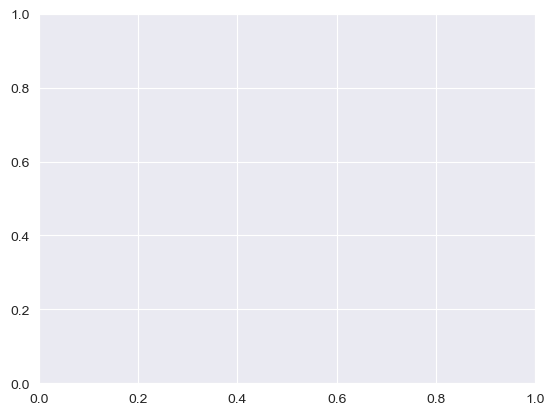

In [11]:
plt.scatter(X_train, y_train, color="blue", label="Actual")
plt.scatter(X_test, y_test, color="red", label="Predicted")
plt.title("DecisionTreeRegressor: Actual vs Predicted")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()